<a href="https://colab.research.google.com/github/pelinsuciftcioglu/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder (VAE)**

VAE implementation inspired by:
- [Tomczak, J. M. (2021). Introduction to Deep Generative Modeling.](https://https://github.com/jmtomczak/intro_dgm)
- [CreativeAI: Deep Learning for Graphics Tutorial Code
](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)





In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os

use_gpu = True

In [51]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

# DISTRBUTION FOR THE DATA (INPUT)

def log_categorical(x, x_new, num_classes, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(x_new, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, x_new, reduction=None, dim=None):
    x_new = torch.clamp(x_new, EPS, 1. - EPS)
    log_p = x * torch.log(x_new) + (1. - x) * torch.log(1. - x_new)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# DISTRIBUTION FOR THE VARIATIONAL INFERENCE
def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


# PRIOR DISTRIBUTIONS for p(z)

def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [52]:
class Encoder(nn.Module):
    def __init__(self, D, H, L):
        super(Encoder, self).__init__()

        self.encoder_net = nn.Sequential(nn.Linear(D, H), nn.LeakyReLU(), nn.Linear(H, H), nn.LeakyReLU(), nn.Linear(H, 2*L))

    def encode(self, x):
      mu, log_var = self.forward(x)
      return mu, log_var

    def forward(self, x):
      h = self.encoder_net(x)
      mu, log_var =  torch.chunk(h, 2, dim=1)

      return mu, log_var

    def sample(self, mu, log_var):
      std = torch.exp(0.5 * log_var)
      # Sample epsilon ~ N(0,I)
      eps = torch.randn_like(std)
      # Reparameterization trick
      z = mu + eps * std

      return z

    def log_prob(self, mu, log_var, z):
      return log_normal_diag(z, mu, log_var)



In [53]:
class Decoder(nn.Module):
    def __init__(self, D, H, L, distribution, num_vals):
        super(Decoder, self).__init__()
        self.D = D
        self.distribution = distribution
        self.num_vals = num_vals

        self.decoder_net = nn.Sequential(nn.Linear(L, H), nn.LeakyReLU(), nn.Linear(H, H), nn.LeakyReLU(), nn.Linear(H, D * num_vals))

    def decode(self, z):
      x_new = self.forward(z)

      return x_new

    def forward(self, z):
      x_new = self.decoder_net(z)
      
      if self.distribution == 'categorical':
        b = x_new.shape[0]
        d = self.D
        x_new = x_new.reshape(b, d, self.num_vals)
        return torch.softmax(x_new, 2)
      
      elif self.distribution == 'bernoulli':
        return torch.sigmoid(x_new)

In [54]:
class Prior(nn.Module):
    def __init__(self, L, prior_distribution):
        super(Prior, self).__init__()
        self.L = L
        self.distribution = prior_distribution

    # def sample(self, batch_size):
    #     z = torch.randn((batch_size, self.L))
    #     return z

    def log_prob(self, z):
      if (self.distribution == 'standard normal'):
        return log_standard_normal(z)

      # elif self.distribution == ''
        # return log____(z)

In [55]:
class VAE(nn.Module):
  def __init__(self, D, H, L, distribution, num_vals, prior_distribution): # Initializations should be added!!!!
        super(VAE, self).__init__()
        self.encoder = Encoder(D, H, L)
        self.decoder = Decoder(D, H, L, distribution, num_vals)
        self.prior = Prior(L, prior_distribution)


        self.num_vals = num_vals
        self.distribution = distribution
  
  def forward(self, x, reduction='avg'):
        x = torch.flatten(x, start_dim=1)
        #print(x.size())
        #print(x[0])
        mu, log_var = self.encoder.encode(x)
        z = self.encoder.sample(mu, log_var)

        ELBO = self.loss(x, z, mu, log_var, reduction)

        return ELBO
  
  def loss(self, x, z, mu, log_var, reduction='avg'):
    # Reconstruction Error
    RE = self.log_prob(x, z)

    # KL-Divergence
    KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu, log_var, z)).sum(-1)

    if reduction == 'sum':
      return -(RE + KL).sum()
    else:
      return -(RE + KL).mean()


  def log_prob(self, x, z):
    x_new = self.decoder.decode(z)

    if self.distribution == 'categorical':
      log_prob = log_categorical(x, x_new, self.num_vals, reduction='sum', dim=-1).sum(-1)
            
    elif self.distribution == 'bernoulli':
      log_prob = log_bernoulli(x, x_new, reduction='sum', dim=-1)

    return log_prob


http://yann.lecun.com/exdb/mnist/

In [56]:
import math
import numbers
import warnings
from enum import Enum

import numpy as np
from PIL import Image

import torch
from torch import Tensor
from typing import List, Tuple, Any, Optional

try:
    import accimage
except ImportError:
    accimage = None


In [57]:
class ToTensor:
    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return to_tensor(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [58]:
def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    This function does not support torchscript.
    See :class:`~torchvision.transforms.ToTensor` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """
    default_float_dtype = torch.get_default_dtype()

    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.to(dtype=default_float_dtype).div(255)
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic).to(dtype=default_float_dtype)

    # handle PIL Image
    mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
    img = torch.from_numpy(
        np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True)
    )

    if pic.mode == '1':
        img = 255 * img
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    # put it from HWC to CHW format
    img = img.permute((2, 0, 1)).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.to(dtype=default_float_dtype)
    else:
        return img

In [59]:
# class ToTensor:
#   def __call__(self, pic):
#     default_float_dtype = torch.get_default_dtype()
#     mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
#     pic = torch.from_numpy(np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True))
#     img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
#     # put it from HWC to CHW format
#     img = img.permute((2, 0, 1)).contiguous()
#     return img.to(dtype=default_float_dtype)

#   def __repr__(self):
#     return self.__class__.__name__ + '()'


In [60]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([ToTensor()])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)


#test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
#test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [61]:
# import tensorflow as tf
# import tensorflow_datasets as tfds

# (ds_train, ds_test), ds_info = tfds.load(
#     'mnist',
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True,
# )

# def castToFloat(image, label):
#   """Normalizes images: `uint8` -> `float32`."""
#   return tf.cast(image, tf.float32), label

# ds_train = ds_train.map(castToFloat, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train = ds_train.batch(128)


In [62]:
likelihood_type = 'categorical'

if likelihood_type == 'categorical':
    num_vals = 256
elif likelihood_type == 'bernoulli':
    num_vals = 1

prior_distribution = 'standard normal'

In [63]:
D = 28*28
H = 98
L = 16


learning_rate = 1e-3
num_epochs = 100

In [64]:
model = VAE(D, H, L, likelihood_type, num_vals, prior_distribution)

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

      # print(data[0])

      # break

      #data = data.requires_grad_(True)   
      #print(data.size())



In [65]:
from torch import autograd


train_loss_avgs = []
best_loss = 1000.

model.train()
print("Training...")

for epoch in range(num_epochs):
  train_loss_avgs.append(0)

  for batch_idx, (data, labels) in enumerate(train_dataloader, 1):


    with autograd.detect_anomaly():

      data = data.to(device)

     
      
      loss = model.forward(data)    
      optimizer.zero_grad()
      loss.backward(retain_graph=True)    
      optimizer.step()    
      train_loss_avgs[-1] += loss.item()
      num_batches = batch_idx

  train_loss_avgs[-1] /= num_batches
  print('Epoch [%d / %d] average training loss: %f' % (epoch+1, num_epochs, train_loss_avgs[-1]))





Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.


Epoch [1 / 100] average training loss: 182816.797745
Epoch [2 / 100] average training loss: 941.475655
Epoch [3 / 100] average training loss: 901.875227
Epoch [4 / 100] average training loss: 880.934248
Epoch [5 / 100] average training loss: 865.473629
Epoch [6 / 100] average training loss: 852.865510
Epoch [7 / 100] average training loss: 842.046179
Epoch [8 / 100] average training loss: 832.676572
Epoch [9 / 100] average training loss: 824.705095
Epoch [10 / 100] average training loss: 817.815327
Epoch [11 / 100] average training loss: 811.267198
Epoch [12 / 100] average training loss: 804.943420
Epoch [13 / 100] average training loss: 798.308011
Epoch [14 / 100] average training loss: 792.083878
Epoch [15 / 100] average training loss: 786.066778
Epoch [16 / 100] average training loss: 779.927880
Epoch [17 / 100] average training loss: 773.453908
Epoch [18 / 100] average training loss: 767.493638
Epoch [19 / 100] average training loss: 761.703338
Epoch [20 / 100] average training los

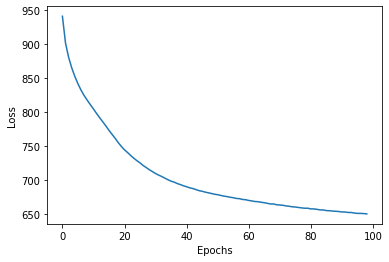

In [68]:
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avgs[1:])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [69]:

import urllib
if not os.path.isdir('./Trained Models'):
    os.makedirs('./Trained Models')

torch.save(model.state_dict(), "./Trained Models/VAE_First")

In [70]:


filename =  "/VAE_First"

print('downloading ...')

model.load_state_dict(torch.load('./Trained Models'+filename))
print('done')


downloading ...
done


In [71]:
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [72]:
# set to evaluation mode
model.eval()

test_loss_avgs, num_batches = 0, 0

for batch_idx, (data, labels) in enumerate(test_dataloader):
    
    with torch.no_grad():
    
        data = data.to(device)

        # reconstruction error
        loss = model.forward(data)

        test_loss_avgs += loss.item()
        num_batches += 1
    
test_loss_avgs /= num_batches
print('average loss: %f' % (test_loss_avgs))

average loss: 798.117806
